# Comparing NIDEM and EOMAP bathy <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** This notebook loads data from an external raster file (`canberra_dem_250m.tif`) from the `Supplementary_data` folder of this repository


## Background
It is often valuable to combine data from the datacube with other external raster datasets. 
For example, we may want to use a Digital Elevation Model (DEM) raster as a mask to focus our analysis on satellite data from areas of low or high elevation.
However, it can be challenging to combine datasets if they have different extents, resolutions (e.g. 30 m vs. 250 m), or coordinate reference systems (e.g. WGS 84 vs. Australian Albers).
To be able to combine these datasets, we need to be able to *reproject* them into identical spatial grids prior to analysis.

Datacube stores information about the location, resolution and coordinate reference system of a rectangular grid of data using an object called a `GeoBox`.
This [GeoBox object](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.geometry.GeoBox.html) is dynamically calculated for all data loaded from the datacube, and all rasters loaded with `xr.open_rasterio` (provided that `import datacube` is run *before* the raster is loaded).
Datacube functions can use this object to provide a template that can be used to reproject raster and datacube data - either applying this reprojection directly when new data is being loaded, or to reproject existing data that has already been loaded into memory.
This makes it straightforward to reproject one dataset into the exact spatial grid of another dataset for further analysis.



## Description
This notebook demonstrates how to perform three key reprojection workflows when working with datacube data and external rasters:

1. Loading and reprojecting datacube data to match a raster file using `dc.load`
2. Reprojecting existing datacube data to match a raster using `xr_reproject`
3. Loading and reprojecting a raster to match datacube data using `rio_slurp_xarray`

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
import datacube
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.masking import mask_invalid_data

sys.path.append("../Scripts")
from dea_plotting import rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Reprojecting_data")

## Loading and reprojecting a raster to match datacube data

Rather than reprojecting satellite data to match the resolution and projection system of our raster, we may instead wish to reproject our raster to match the spatial grid of our satellite data.
This can be particularly useful when we have a lower resolution raster file (e.g. like the ~250 m resolution DEM we are using in this example), but we don't want to lose the better spatial resolution of our satellite data. 

### Load datacube data
As in the previous example, we can load in satellite data from the datacube at 30 m spatial resolution and Australian Albers (`EPSG:3577`) coordinate reference system:

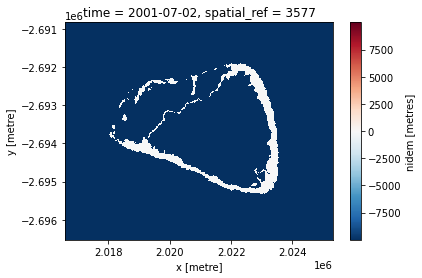

In [76]:
# Load data from datacube
ds = dc.load(product="nidem",
             x=(152.03, 152.11),
             y=(-23.52, -23.48)).squeeze('time')

# # Load data from datacube
# ds = dc.load(product="nidem",
#              x=(151.414247, 152.493538),
#              y=(-22.860606, -23.956338)).squeeze('time')


# Set nodata
# ds = ds.where(ds.nidem != -9999)

ds.nidem.plot()

### Load and reproject raster data
We can now use the `rio_slurp_xarray` function to load and reproject our raster file to match our higher resolution satellite dataset.
We pass `ds.geobox` to the function to request that our raster gets reprojected to match the spatial grid of `ds`.
As in the previous `xr_reproject` example, we can also specify a custom `resampling` method which will be used during the reprojection.
In this case, we specify `'bilinear'`, which will produce a smooth output without obvious pixel boundaries.

> **Note:** Refer to the [rasterio documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) for a full list of available resampling methods.

In [104]:
raster_path='GBR_bathy/SDB_AUS_MackayCapricorn_EOMAP_20170515_20181022_10m_MSL_geotiff.tif'

# Load raster and reproject to match satellite dataset
raster_reprojected = rio_slurp_xarray(raster_path,
                                      ds.geobox,
                                      resampling="bilinear")

# Set nodata to `NaN`
raster_reprojected = mask_invalid_data(raster_reprojected)

If we plot our resampled raster data, it should now appear less pixelated than the original ~250 m resolution raster.

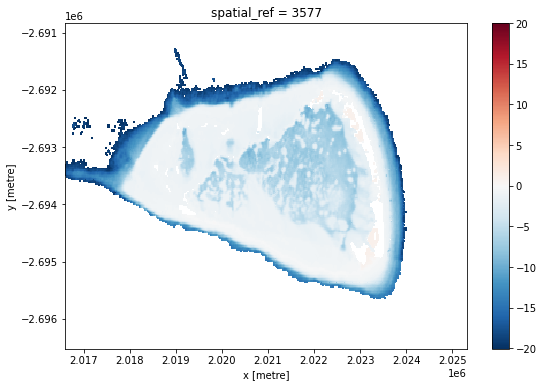

In [105]:
raster_reprojected.plot(size=6)

In [79]:
# gbr_bathy_masked = raster_reprojected.where(~ds.nidem.isnull())
# gbr_bathy_masked.plot()

In [106]:
valid_mask = (ds.nidem.values != -9999) & (~raster_reprojected.isnull())
nidem_vals = ds.nidem.values[valid_mask]
gbrbathy_vals = raster_reprojected.values[valid_mask]

(-2.0, 2.0)

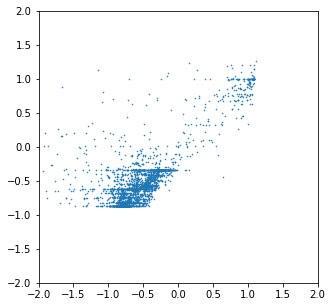

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x=gbrbathy_vals, y=nidem_vals, s=0.3)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
# axes.set_ylim([ymin,ymax])

/env/lib/python3.6/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.06`, but please update your code.
  warnings.warn(msg, UserWarning)


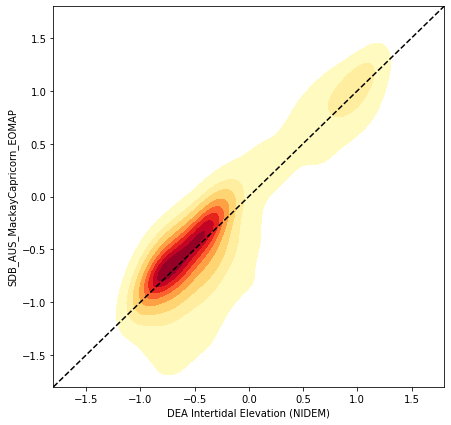

In [129]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.kdeplot(
    x=nidem_vals, y=gbrbathy_vals, fill=True, thresh=0.06, levels=9, cmap="YlOrRd",  shade_lowest=False,
)
plt.ylim(-1.8, 1.8)
plt.xlim(-1.8, 1.8)
plt.ylabel('SDB_AUS_MackayCapricorn_EOMAP')
plt.xlabel('DEA Intertidal Elevation (NIDEM)')
y_lim = plt.ylim()
x_lim = plt.xlim()
plt.plot(x_lim, y_lim, 'k-', color = 'black', linestyle='--')

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import math
from scipy.stats import pearsonr

rmse = math.sqrt(mean_squared_error(gbrbathy_vals, nidem_vals, squared=True))
mae = mean_absolute_error(gbrbathy_vals, nidem_vals)
corr = pearsonr(gbrbathy_vals, nidem_vals)[0]
print(rmse, mae, corr)

0.4777889572989999 0.22211705 0.6770059558335104


The resampled raster should also match the spatial grid of our higher resolution satellite data:

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)